In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from scipy.misc import imsave

In [2]:
imsize = 32

In [3]:
class Agent:
    def __init__(self, positive):
        
        self.positive = positive
        
        if positive:
            self.color = np.array([1,0,0], dtype='int64')
            self.size = np.random.randint(low=1, high=3, size=2)
        else:
            self.color = np.random.normal(size=3)
            self.size = np.random.randint(low=4, high=6, size=2)
        
        self.pos = np.random.randint(low=0, high=imsize-1, size=2)
        self.v = np.random.normal(size=2)*2.5
        
    def correct_pv(self):
        #correct position and velocity
        pos = self.pos
        v = self.v
        s = self.size
        
        if pos[0] + s[0] >= imsize:
            v[0] *= -1
            pos[0] = imsize - s[0] - 1
            
        if pos[1] + s[1] >= imsize:
            v[1] *= -1
            pos[1] = imsize - s[1] - 1
        
        if pos[0] - s[0] < 0:
            v[0] *= -1
            pos[0] = s[0]
            
        if pos[1] - s[1] < 0:
            v[1] *= -1
            pos[1] = s[1]
        
        self.pos = pos
        self.v = v
    def plot_on_image(self, im):
        pos = self.pos
        s = self.size
        
        im[pos[0] - s[0]:pos[0] + s[0], pos[1] - s[1]:pos[1] + s[1]] = self.color
        
        bcol = np.array([1,1,1], dtype='float')
        im[0,:] = bcol
        im[-1,:] = bcol
        im[:,0] = bcol
        im[:,-1] = bcol
        
    def step(self):
        self.v += np.random.normal(size=2)/4
        self.v = np.clip(self.v, -2, 2)
        
        self.pos = (self.v + self.pos).astype('int64')
        self.correct_pv()
    
    def bbox(self):
        pos = self.pos
        s = self.size
        return [pos[0] - s[0], pos[1] - s[1], pos[0] + s[0], pos[1] + s[1]]

In [4]:
def create_video(num_positive, num_negative, length):
    im = np.zeros([imsize, imsize, 3])
    apos = [Agent(True) for _ in range(num_positive)]
    afal = [Agent(False) for _ in range(num_negative)]
    
    imgs = []
    bboxes = []
    
    for _ in range(length):
        im = np.zeros([imsize, imsize, 3])

        for agents in [apos, afal]:
            [ag.step() for ag in agents]
            [ag.plot_on_image(im) for ag in agents]

        imgs.append(im)
        
        bboxes.append( [ag.bbox() for ag in apos] )
        
    return np.array(imgs), bboxes

In [5]:
video, bboxes = create_video(2,3,4)

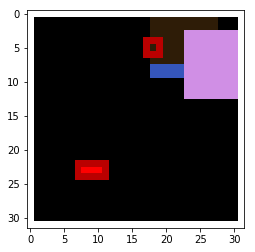

In [6]:
for im, bb in zip(video, bboxes):
    for b in bb:
        cv2.rectangle(im,(b[1], b[0]), (b[3], b[2]), 70)
        pass
    plt.imshow(im)
    plt.show()
    break

In [7]:
bboxes[0]

[[4, 17, 6, 19], [22, 7, 24, 11]]

In [8]:
video_dir = './videos/'
annotations_dir = './annotations/'

In [9]:
!rm -R videos/*
!rm annotations/*

In [10]:
for vnum in range(20):
    cdir = os.path.join(video_dir,str(vnum))
    os.mkdir(cdir)
    video, frame_bbs = create_video(2,2,np.random.randint(low=10, high=500))
    for i, frame in enumerate(video):
        imsave(os.path.join(cdir, str(i) + '.jpg'), frame)
    
    annot_file = os.path.join(annotations_dir,str(vnum)) + '.txt'
    with open(annot_file, 'w') as f:
        for i, frame in enumerate(frame_bbs):
            for bb in frame:
                f.write(','.join([str(i)] + list(map(str, bb))) + '\n')